# Estimating the Tail - Double Bootstrap #

## Tail Quest ##

While the PoT method is perhaps the oldest and most well-known tail-estimation method, a more quantitative and analytical approach is preferred. But the quest for a signal method remains elusive: so much so that this paper catalogues literally [100+ tail estimators](https://mpra.ub.uni-muenchen.de/90072/1/MPRA_paper_90072.pdf).

Of those methods, the Hill estimator is another popular approach particularly useful for Pareto distributions, defined as:

$$
\alpha_{n,\kappa} = {\kappa}\left[\sum\limits_{i=1}^{\kappa}log\frac{x_{i}}{x_{\kappa+1}}\right]^{-1}
$$

where: $x_i$ is an i.i.d. descending ordered statistic such that $x_1 >= x_2 ... >= x_n$

This can be reframed in terms of $\xi$ from the Extreme Value and Generalized Pareto Distributions as:

$$
\xi_{n,\kappa} = \frac{1}{\kappa}\sum\limits_{i=1}^{\kappa}log\frac{x_{i}}{x_{\kappa+1}}
$$

where: $$\xi = \frac{1}{\alpha}$$

The log of a Pareto is understood to be exponential, so this is essentially the exponential first moment calculation for every $\kappa th$ largest sample where the $\kappa th$ sample is assumed to be the true location parameter.

The Hill Estimator is known to be [asymptotically stable](https://projecteuclid.org/journals/annals-of-statistics/volume-28/issue-1/How-to-make-a-Hill-plot/10.1214/aos/1016120372.full) for certain Pareto distributions. We can see this, for instance, with Pareto Type-I below.

In [24]:
def hill_est_for_alpha(k, y):
    return k / (np.cumsum(np.log(y[:-1])) - k*np.log(y[1:]))

def hill_est_for_xi(k,y):
    return np.cumsum(np.log(y[:-1]))/k - np.log(y[1:])

In [7]:
import numpy as np
import scipy.stats as scist
import matplotlib.pyplot as plt

n = 10000
a, x_m= 5, 5
par = scist.pareto(a, loc=x_m)
y = par.rvs(size=n)
y = np.sort(y)[::-1]
y = y - x_m
k = np.arange(1,n)
par_hill = hill_est_for_alpha(k,y)

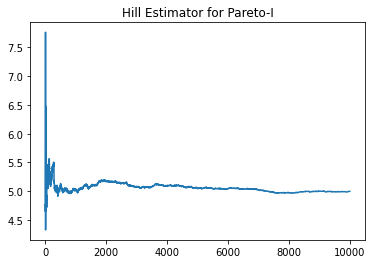

In [12]:
plt.plot(par_hill)
plt.title('Hill Estimator for Pareto-I')
plt.show()

Using a Generalized Pareto parameterized equivalent to a Pareto-I results in the same clear asymptote at the expected value.

In [10]:
n = 10000
xi = 1/a
scale = x_m*xi
loc = scale / xi
gp = scist.genpareto(xi, loc=loc)
y = gp.rvs(size=n)
y = np.sort(y)[::-1]
k = np.arange(1,n)
hill_gp = hill_est_for_xi(k,y)

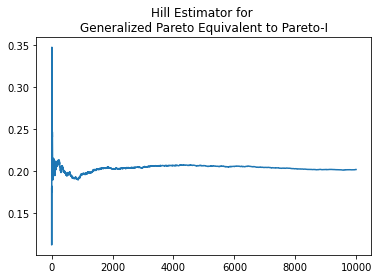

In [15]:
plt.plot(hill_gp)
plt.title('Hill Estimator for \nGeneralized Pareto Equivalent to Pareto-I')
plt.show()

When Generalized Pareto deviates from Pareto equivalence, however, the Hill estimator is not as revealing. As per plot below, there is no obvious asymptote or stable value maintained for any region of $\kappa$ when we adjust $\text{scale}=.02$

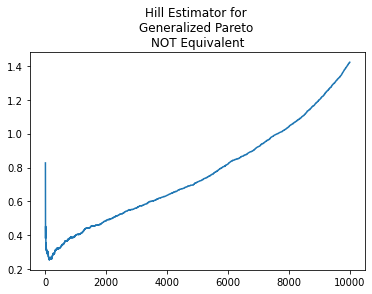

In [19]:
n = 10000
xi = 1/a
scale = .02
loc = 1/4
gp = scist.genpareto(xi, loc=loc)
y = gp.rvs(size=n)
y = np.sort(y)[::-1]
k = np.arange(1,n)
hill_gp2 = hill_est_for_xi(k,y)

plt.plot(hill_gp2)
plt.title('Hill Estimator for \nGeneralized Pareto \nNOT Equivalent')
plt.show()

And, of course, similar behavior is shown in the above-mean values of the S&P 500 returns.

[*********************100%***********************]  1 of 1 completed


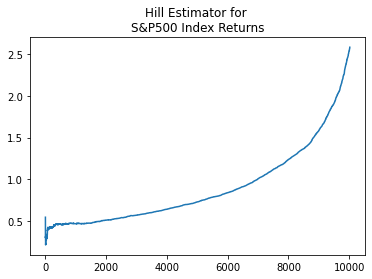

In [23]:
import yfinance as yf

sp = yf.download('^GSPC')
sp_ret = sp.Close.pct_change()[1:]

pos = sp_ret[sp_ret > sp_ret.mean()]
pos = np.sort(pos)[::-1]

k = np.arange(1, pos.shape[0])
hill_sp = hill_est_for_xi(k, pos)

plt.plot(hill_sp)
plt.title('Hill Estimator for \nS&P500 Index Returns')
plt.show()

## the Hill Double Bootstrap ##

The Hill Double Bootstrap is one quantitative approach that narrows in on a valid tail index estimate when one is not evident visually. The technique is outlined by [Voitalov (2019)](references.ipynb) building on [Danielsson (2001)](references.ipynb).

The approach is based on a quantity known as the Asymptotic Mean Squared Error, AMSE, defined as:

$$\text{AMSE}(n, \kappa) = E[(\hat{}_{n, \kappa} - \xi)^2]$$

In this definition, $\xi$ is an unknown true value. The Double Bootstrap replaces the true value with a second estimator, so that:

$$
\text{AMSE}(n, \kappa) = E[(\hat{\xi}^{(2)}_{n_1, \kappa_j} - \hat{\xi}^{(1)}_{n_2, \kappa_j})^2]
$$

where $\hat{\xi}^{(1)} \text{and } \hat{\xi}^{(2)}$ are found via the first and second moments of the tail index of the sample (with the first moment being the Hill estimator), resulting in:

$$
\text{AMSE}(n, \kappa) = E[(M_{\xi}(2) - 2M_{\xi}^2(1))^2]
$$

The goal of the approach is for the two estimators to converge, with their convergence value being the true value. The procedure is as follows:

1. Repeat $r$ number of iterations through the data, drawing $n_1$ samples for each iteration.
2. For each $\kappa$ in $n_1$, find the first estimator, the Hill estimate which is the sample's first moment:
$$
M_{1,\kappa_1} = \frac{1}{\kappa_1}\sum\limits_{i=1}^{\kappa}ln\frac{x_i}{x_{k+1}}
$$
3. For each $\kappa$ in $n_1$, find the second estimator, which is derived from the sample's second moment: 
$$
M_{2,\kappa_1} = \frac{1}{\kappa_1}\sum\limits_{i=1}^{\kappa}(ln\frac{x_i}{x_{k+1}})^2
$$
4. Find $\kappa_1^*$ that minimizes 
$\frac{1}{r}\sum\limits_{j=1}^r(M_{2,\kappa_1} - 2(M_{1,\kappa_1})^2)^2$ 
*(adjustment applied to $M_1$ as it has a different multiplicative constant)*

5. Repeat 1. thru 4. with a second sample of size $n_2$ and find $\kappa_2^*$
6. Find $\kappa^* = A(\kappa_1^*, n_1, n)\frac{(\kappa_2^*)^2}{\kappa_1^*}$
7. Then, the tail index is $\xi = M_1,{\kappa^*}$

where:
$
r: \text{number of bootstrap samples}
\\t \in [0,1]: \text{proportion between bootstrap sample sizes}
\\n_1 = \sqrt{t}n
\\n_2 = tn
\\\kappa_i = 1 ... n_i
$

$A(.)$ has a non-trivial derivation outlined in [Daniellson (2001) as Corollary 7](references.ipynb). Voitalov (2019) also points to a different factor arrived at by [Qi (2008)](references.ipynb).

We will demonstrate the process for both tails of a random sample from the Phat distribution.

1. Begin by creating a generative model Phat distribution and generating a set of random samples. 
2. Isolate samples in the right tail. We will cutoff the data at the sample mean and not the right tail location as technically this location should be an unknown.
3. Sort the remaining samples from descending order.
4. Define several parameters consistent with Voitalov (2019).

In [33]:
from phat import Phat

genmod = Phat(.25, 1.4, .35, .22)
data = genmod.rvs(size=100000)
y = data[data>=data.mean()]
y = np.sort(y)[::-1]

r = 500
t = .5
n = y.size
n1 = int(np.sqrt(t)*n)
n2 = int(t*n)
k = np.arange(1, y.size)

Our first order of business is to find the Hill estimate at each $\kappa$ for the entire dataset. We already have a function for this.

In [35]:
with np.errstate(invalid='ignore'):
    xi = hill_est_for_xi(k,y)

In the plot, we see the familiar exploding tail.

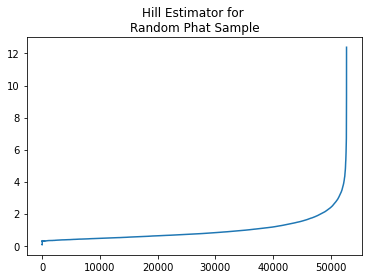

In [44]:
plt.plot(xi)
plt.title('Hill Estimator for \nRandom Phat Sample')
plt.show()

Now we implement the iterative process through $r$ for sample size $n_1$:

For r iterations:

1. Pull $n_1$ samples from the data.
2. Sort the samples in ascending order
3. Find the first moment, $M(1)$ (the Hill estimator), and second moment, $M(2)$.
4. Find the AMSE between the two moment estimators.

After iterating:

5. Find the mean of the accumulated errors in each $\kappa$ across the $r$ iterations
6. $\kappa*$ is the index of the minimum mean AMSE

In [39]:
def second_moment(k, y):
    t1 = np.cumsum(np.log(y[:-1])**2) / k 
    t2 = 2*np.cumsum(np.log(y[:-1]))*np.log(y[1:]) / k
    t3 = np.log(y[1:])**2
    return t1 - t2 + t3

def amse(M1, M2):
    return (M2 - 2*M1**2)**2

In [41]:
def third_moment(k,y):
    t1 = (1/k)*np.cumsum(np.log(y[:-1])**3)
    t2 = (3*np.log(y[1:])/k)*np.cumsum(np.log(y[:-1])**2)
    t3 = (3*np.log(y[1:])**2/k)*np.cumsum(np.log(y[:-1]))
    t4 = np.log(y[1:])**3
    M3 = t1 - t2 + t3 - t4
    return M3

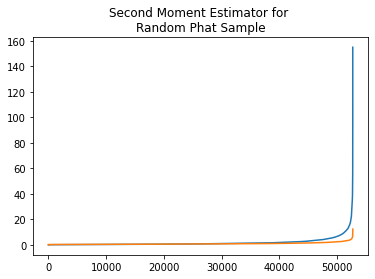

In [45]:
plt.plot(second_moment(k,y))
plt.plot(xi)
plt.title('Second Moment Estimator for \nRandom Phat Sample')
plt.show()

In [46]:
import warnings

i_kmin = 1
i_kmax = (np.abs(np.linspace(1./n1, 1.0, n1) - 1)).argmin()
amses = np.zeros((r, n1-1))
for i in range(r):
    sample = np.random.choice(y, n1, replace=True)
    sample = np.sort(sample)[::-1]
    k = np.arange(1,n1)
    M1 = hill_est_for_xi(k,sample)
    M2 = second_moment(k,sample)
    amses[i] = amse(M1,M2)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    amse_for_k = np.nanmean(amses, axis=0)

k1 = np.nanargmin(amse_for_k[i_kmin:i_kmax]) + 1 + i_kmin
k1

259

Next we repeat the iterative process through $r$ for sample size $n_2$. The process is encapsulated in the `k_finder` function.

In [48]:
from phat.bootstrap.numpy import k_finder

k2 = k_finder(y, n2, r, 1)
k2

192

One implication of the procedure above is the assumption of `k_min=1`. If $\kappa_2 > \kappa_1$, this may be evidence that the assumption is incorrect. So the `r` iterative process for each $\kappa$ is repeated until $\kappa_2 <= \kappa_1$ as outlined in [Voitalov (2019)](references.ipynb).

In [49]:
kmin1, kmin2 = 1,1
while True:
    k1 = k_finder(y, n1, r, kmin1)
    k2 = k_finder(y, n2, r, kmin2)

    if k2 > k1:
        kmin1 += int(0.005*n)
        kmin2 += int(0.005*n)
    else:
        break

We now find our $\kappa^*$ as $A(\kappa_1^*, n_1, n)\frac{(\kappa_2^*)^2}{\kappa_1^*}$. As noted, A(.) has a couple of formulas. We use the Qi formulation here, but Daniellson is also avialable.

In [52]:
from phat.bootstrap.numpy import A_qi

k_star = A_qi(n1,k1)*k1**2 / k2
k_star = np.round(k_star).astype(int)
xi[k_star]

0.2795572868509768

We can see the estimate is failry close to the actual value utilized. 

We can repeat this process for the left tail, this time using the `dbl_bs` function which encapsulates the above process. When examining the left tail, we simply have to negate the values.

In [53]:
import itertools as it
from tqdm.notebook import tqdm, trange
from phat.bootstrap.numpy import dbl_bs

In [54]:
y_left = data[data<data.mean()]
y_left = np.sort(-y_left)[::-1]

xi_star = dbl_bs(y_left, t=.5, r=500, style='hill', A_type='qi')
xi_star

0.3878396951275236

Once again we have decent agreement with the actual tail.

### Testing ###

We will consider the impact of different parameter selection on double bootstrap performance. First, we consider different combinations of a sample proportions (`t`) and number of samples (`r`).

In [61]:
ts= np.linspace(.1, .8, 5)
rs = np.array([100, 250, 500, 1000, 2500])
results = []
for t, r in tqdm(it.product(ts, rs), total=ts.size*rs.size):
    for i in trange(4, leave=False):
        xi_left = dbl_bs(y_left, t=t, r=r, style='hill', A_type='qi')
        xi_right = dbl_bs(y, t=t, r=r, style='hill', A_type='qi')
        res = {}
        res['t'] = t
        res['r'] = r
        res[r'$\hat \xi_{left}$'] = xi_left
        res[r'$\hat \xi_{right}$'] = xi_right
        results.append(res)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [92]:
import pandas as pd

# df = pd.DataFrame(results)
# df.to_csv('dbs_test_on_r_and_t.csv', index=False)
df = pd.read_csv('dbs_test_on_r_and_t.csv')
df_avg = pd.DataFrame(df.values.reshape(-1, 4, df.values.shape[1]).mean(axis=1), columns=df.columns)
df_avg.columns = ['t', 'r', r'$\hat \xi_{left}$', r'$\hat \xi_{right}$']
df_avg[r'$\xi_{left}$'] = genmod.shape_l
df_avg[r'$\xi_{right}$'] = genmod.shape_r
df_avg = df_avg[[
    't', 'r', r'$\hat \xi_{left}$', 
    r'$\xi_{left}$', r'$\hat \xi_{right}$',
    r'$\xi_{right}$'
]]

df_avg.style.format('{:.4}')

,t,r,$\hat \xi_{left}$,$\xi_{left}$,$\hat \xi_{right}$,$\xi_{right}$
0,0.1,100.0,0.3903,0.35,0.2996,0.22
1,0.1,250.0,0.3891,0.35,0.3039,0.22
2,0.1,500.0,0.389,0.35,0.3125,0.22
3,0.1,1e+03,0.3902,0.35,0.3129,0.22
4,0.1,2.5e+03,0.3876,0.35,0.3129,0.22
5,0.275,100.0,0.3875,0.35,0.2936,0.22
6,0.275,250.0,0.3918,0.35,0.2814,0.22
7,0.275,500.0,0.3897,0.35,0.2827,0.22
8,0.275,1e+03,0.3867,0.35,0.2824,0.22
9,0.275,2.5e+03,0.3891,0.35,0.284,0.22


We can see from the above that the Hill leads to fairly consistent results, irrespective of the `t` and `r` methods selected. The Hill does seem to overestimate both tails slightly.

We then ran hundreds of simulations for different combinations of dataset size, $n$ and left/right tail indices.

In [94]:
results = []
ns = np.logspace(3.75,5.35,5).astype(np.int)
tails = np.array([.1,.2,.35, .5, 1, 2.5, 5])

loop = it.product(ns, it.product(tails, tails))
try:
    for n, xi in tqdm(loop, total=ns.size*tails.size):
        genmod = Phat(.25, 1.4, *xi)
        data = genmod.rvs(size=n)
        y_left = data[data<0]
        y_left = np.sort(-y_left)[::-1]
        y_right = data[data>0]
        y_right = np.sort(y_right)[::-1]
        for i in trange(4, leave=False):
            xi_lest = dbl_bs(y_left, t=.5, r=500, style='hill', A_type='qi')
            xi_rest = dbl_bs(y_right, t=.5, r=500, style='hill', A_type='qi')
            res = {}
            res['t'] = .5
            res['r'] = 500
            res['n'] = n
            res['mean'] = data.mean()
            res['xi_lactual'], res['xi_ractual'] = xi
            res['xi_lest'] = xi_lest
            res['xi_rest'] = xi_rest
            results.append(res)
except Exception as e:
    print (n, np.sqrt(t)*n, t*n, xi[0], xi[1], .5, 500)
    raise e

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [135]:
# df = pd.DataFrame(results)
# df.to_csv('dbs_test_on_sample_size_and_tails.csv', index=False)

A sample of the resulting dataset is found below.

In [133]:
df = pd.read_csv('dbs_test_on_sample_size_and_tails.csv')

df['left_err'] = df.xi_lactual - df.xi_lest
df['right_err'] = df.xi_ractual - df.xi_rest
df['left_err_per'] = df['left_err'] / df.xi_lactual
df['right_err_per'] = df['right_err'] / df.xi_ractual
df_avg = pd.DataFrame(df.values.reshape(-1, 4, df.values.shape[1]).mean(axis=1), columns=df.columns)
df_avg.head()

,t,r,n,mean,xi_lactual,xi_ractual,xi_lest,xi_rest,left_err,right_err,left_err_per,right_err_per
0,0.5,500.0,5623.0,0.182551,0.1,0.10,0.097219,0.134701,0.002781,-0.034701,0.027814,-0.347012
1,0.5,500.0,5623.0,0.429313,0.1,0.20,0.209265,0.080751,-0.109265,0.119249,-1.092648,0.596247
2,0.5,500.0,5623.0,0.798177,0.1,0.35,0.258230,0.424439,-0.158230,-0.074439,-1.582302,-0.212683
3,0.5,500.0,5623.0,1.306846,0.1,0.50,0.248660,0.588241,-0.148660,-0.088241,-1.486602,-0.176482
4,0.5,500.0,5623.0,12.759773,0.1,1.00,0.242512,1.056910,-0.142512,-0.056910,-1.425120,-0.056910


The data has been summarized into a few plots per below.

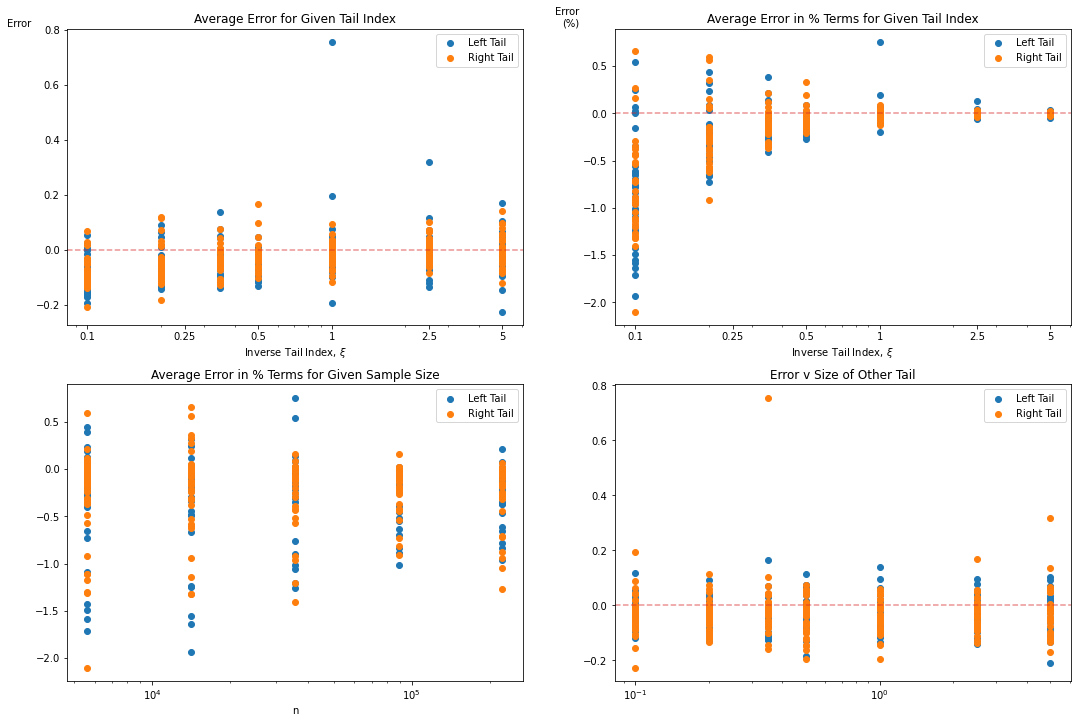

In [136]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(18,12))

ax1.scatter(df_avg.xi_lactual, df_avg.left_err, label='Left Tail')
ax1.scatter(df_avg.xi_ractual, df_avg.right_err, label='Right Tail')
ax1.axhline(0, c='C3', ls='--', alpha=.5)
ax1.set_xscale('log')
ax1.set_xticks([.1, .25, .5, 1, 2.5, 5])
ax1.set_xticklabels([.1, .25, .5, 1, 2.5, 5])

ax1.set_xlabel(r'Inverse Tail Index, $\xi$')
ax1.set_ylabel('Error', loc='top', rotation='horizontal')
ax1.legend()

ax2.scatter(df_avg.xi_lactual, df_avg.left_err_per, label='Left Tail')
ax2.scatter(df_avg.xi_ractual, df_avg.right_err_per, label='Right Tail')
ax2.axhline(0, c='C3', ls='--', alpha=.5)
ax2.set_xscale('log')
ax2.set_xticks([.1, .25, .5, 1, 2.5, 5])
ax2.set_xticklabels([.1, .25, .5, 1, 2.5, 5])

ax2.set_xlabel(r'Inverse Tail Index, $\xi$')
ax2.set_ylabel('Error\n(%)', loc='top', rotation='horizontal')
ax2.legend()

ax3.scatter(df_avg.n, df_avg.left_err_per, label='Left Tail')
ax3.scatter(df_avg.n, df_avg.right_err_per, label='Right Tail')
ax3.set_xscale('log')
ax3.set_xlabel('n')
ax3.legend()

ax4.scatter(df_avg.xi_lactual, df_avg.right_err, label='Left Tail')
ax4.scatter(df_avg.xi_ractual, df_avg.left_err, label='Right Tail')
ax4.axhline(0, c='C3', ls='--', alpha=.5)
ax4.set_xscale('log')
ax4.legend()

ax1.set_title('Average Error for Given Tail Index')
ax2.set_title('Average Error in % Terms for Given Tail Index')
ax3.set_title('Average Error in % Terms for Given Sample Size')
ax4.set_title('Error v Size of Other Tail')

plt.show()

We can see the tail estimator is fairly consisten in terms of the range of error in the tail estimation (usually between [-.2,.2]), but these absolute values can have a significant impact for smaller tail indices. For example, for a true tail index of $\xi = .1$, a .20 error is >200% in relative terms. And the impact of a 3x tail versus a 10x tail is enormous.

So care should be taken where the dataset is believe to have a smaller tail index.

### Caveats ###

+ One assumption required for the Hill Double Bootstrap is that the regularly varying distribution of the samples satisfies the second-order condition and the generalized Pareto does *not*. See [Voitalov (2019)](references.ipynb) for a discussion of this. Voitalov sees the consistent convergence of the method to the true tail as evidence that some other as yet unknown property of the Pareto allows for this method.

+ [Danielsson (2016)](references.ipynb) recently indicated that the Double Bootstrap technique losses strength in the deeper tails and suggested a procedure utilizing the Kolmogorov-Smirnov
statistic as a penalty function.